## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/BTP/NN")

In [3]:
!ls

'Linear Regression.ipynb'   Model3.ipynb	  __pycache__
 Model1.ipynb		    Network.py		  SlidingWindows.py
 Model2.ipynb		    Neuralnetwork.ipynb


## Import Modules and Data

In [4]:
import numpy as np
import pandas as pd
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
from SlidingWindows import *
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [5]:
data = pd.read_csv('../data/sales_train_validation.csv')
calender = pd.read_csv('../data/calendar.csv')

In [6]:
def divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

In [7]:
def RMSE(pred, original):
  residuals = pred - original
  # lr_residuals = pred - testset.iloc[:, -1].values.reshape(-1,1)
  return np.sqrt(np.sum(np.power(residuals,2)) / len(residuals))

In [8]:
def GetDistribution(category="HOBBIES", start=400, end=1913, MAX=1913, states=[]):
  cat_id = category
  
  state_id_1 = states[0]
  category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_1)].to_numpy()[:,6:]
  category_state.shape
  y1 = np.sum(category_state, axis = 0)
  # print(y1.shape)

  state_id_2 = states[1]
  category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_2)].to_numpy()[:,6:]
  category_state.shape
  y2 = np.sum(category_state, axis = 0)
  # print(y2.shape)

  state_id_3 = states[2]
  category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_3)].to_numpy()[:,6:]
  category_state.shape
  y3 = np.sum(category_state, axis = 0)

  distribution = {}

  for s in zip(states, [y1, y2, y3]):
    # print(s[0])
    mean_y = divide(s[1], (y1 + y2 + y3))[start:end].mean()
    distribution[s[0]] = [i if i > 0 and i < 1 else mean_y for i in divide(s[1], (y1 + y2 + y3))[start:end]]
  
  return distribution

In [9]:
def GetCalenderData(start=0, end=1913):
  for evnt in calender.event_type_1.dropna().unique():
    calender[f'{evnt.lower()}_1'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_1]

  for evnt in calender.event_type_1.dropna().unique():
    calender[f'{evnt.lower()}_2'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_2]

  calender_train_data = calender.iloc[:,11:][start:end].reset_index(drop=True)
  return calender_train_data

In [10]:
def GetPreviousDayY(t, distribution, shift=7*52, period=7, start=0, end=1913, states=[]):
  sz = end - start
  previous_days_y = np.array([t])
  columns = ['t']
  k = 1
  for state in states:
    for index, s in enumerate(range(7, shift + 1, period)):
      columns.append('x' + str(k) + str(s // period))
      x = np.array([distribution[state][i-s] if i - s >= 0 else 0 for i in range(0,sz)])
      previous_days_y = np.vstack([previous_days_y, x])
    k += 1
  
  return (columns, previous_days_y)

# previous_days_y.shape

In [11]:
def BuildDataset(category="HOBBIES"):
  states = ['CA', 'TX', 'WI']
  shift = 7 * 52
  period = 7
  start = 400
  end = 1913
  MAX = 1913
  sz = end - start

  t = np.array(range(1, MAX + 1))[start:end]

  distribution = GetDistribution(category=category, states=states)
  calender_train_data = GetCalenderData(start=start, end=end)
  columns, previous_days_y = GetPreviousDayY(t, distribution, states=states, start=start, end=end)

  dataset = pd.DataFrame(np.transpose(previous_days_y), columns = columns)
  dataset = pd.concat([dataset, calender_train_data], axis=1)
  dataset = dataset.iloc[shift:,:].reset_index(drop=True)

  for index, state in enumerate(states): 
    dataset['y' + str(index + 1)] = distribution[state][shift:]
  return dataset

In [20]:
def train(dataset):
  
  states = ['CA', 'TX', 'WI']
  drop_columns = [['snap_TX', 'snap_WI', 'y2', 'y3'], ['snap_WI', 'snap_CA', 'y1', 'y3'], ['snap_TX', 'snap_CA', 'y2', 'y1']]

  trainset = {}
  testset = {}
  predictions = {}
  predictions_train = {}  

  for index, state in enumerate(states):
    dataset_train = dataset.drop(drop_columns[index], axis=1)
    trainset[state], testset[state] = train_test_split(dataset_train, test_size = 0.2, shuffle = False)
    X = trainset[state].iloc[:,1:-1]
    y = trainset[state].iloc[:,-1].values.reshape(-1,1)
    ##LEARNING MODEL
    reg = LinearRegression().fit(X, y)
    predictions_train[state] = reg.predict(X)
    predictions[state] = reg.predict(testset[state].iloc[:,1:-1])

  return predictions, testset, predictions_train, trainset

In [24]:
def PlotGraphs(dataset, predictions, start=100, end=200): 
  fig, axs = plt.subplots(3, 3, figsize=(25,15))

  categories = ['HOBBIES', "FOODS", "HOUSEHOLD"]
  states = ['CA', 'TX', 'WI']
  k = 0
  l = 0

  for index, ax in enumerate(axs.reshape(-1)):
    cat_id = categories[l] 
    state_id = states[k]
    ax.plot(dataset[cat_id][state_id]['t'][start:end], dataset[cat_id][state_id]['y' + str(index % 3 + 1)][start:end], marker='o', label="original")
    ax.plot(dataset[cat_id][state_id]['t'][start:end], predictions[cat_id][state_id][:,0][start:end], 'tab:orange', marker='o', label="prediction")
    ax.set_title(f'Distribution of category {cat_id} in {state_id}')
    ax.set(xlabel='Day', ylabel='Contribution')
    ax.legend(loc="upper right")
    k += 1
    if(k % 3 == 0): 
      l += 1
      k = 0


### Build Dataset

In [14]:
categories = ['HOBBIES', "FOODS", "HOUSEHOLD"]
states = ['CA', 'TX', 'WI']
dataset = {}

for index, cat in enumerate(categories):
  dataset[cat] = BuildDataset(category=cat)

### Train the model

In [21]:
predictions = {'FOODS': {},'HOUSEHOLD': {}, 'HOBBIES': {}}
prediction_train = {'FOODS': {},'HOUSEHOLD': {}, 'HOBBIES': {}}
testset = {'FOODS': {},'HOUSEHOLD': {}, 'HOBBIES': {}}
trainset = {'FOODS': {},'HOUSEHOLD': {}, 'HOBBIES': {}}

for cat in categories:
  print('Training for category ' + cat)
  predictions[cat], testset[cat], prediction_train[cat], trainset[cat]  = train(dataset[cat])

Training for category HOBBIES
Training for category FOODS
Training for category HOUSEHOLD


In [22]:
print("RMSE on Trainset", end="                       ")
print("RMSE on Testset")
for cat in categories:
  print("Category = " + cat, end="\n")
  # print("Category = " + cat)
  for state in states:
    print("State " + state + ": " + str(RMSE(predictions[cat][state], testset[cat][state].iloc[:,-1].values.reshape(-1, 1))), end="        ")
    print("State " + state + ": " + str(RMSE(prediction_train[cat][state], trainset[cat][state].iloc[:,-1].values.reshape(-1, 1))))
  print("--------------------------------------------------------------------------")


RMSE on Trainset                       RMSE on Testset
Category = HOBBIES
State CA: 0.029413285984468778        State CA: 0.024505496880009185
State TX: 0.024497771260431678        State TX: 0.021986561939894258
State WI: 0.026206410289296718        State WI: 0.02143483955265317
--------------------------------------------------------------------------
Category = FOODS
State CA: 0.020562127526026836        State CA: 0.01866834554814212
State TX: 0.022840415175486673        State TX: 0.020983779601213986
State WI: 0.019980922306340933        State WI: 0.0176417277597604
--------------------------------------------------------------------------
Category = HOUSEHOLD
State CA: 0.02260233708997259        State CA: 0.017562862227319846
State TX: 0.01900207397297958        State TX: 0.015469692817243507
State WI: 0.023394347119974433        State WI: 0.016797702163062353
--------------------------------------------------------------------------


### Plot the results for training data

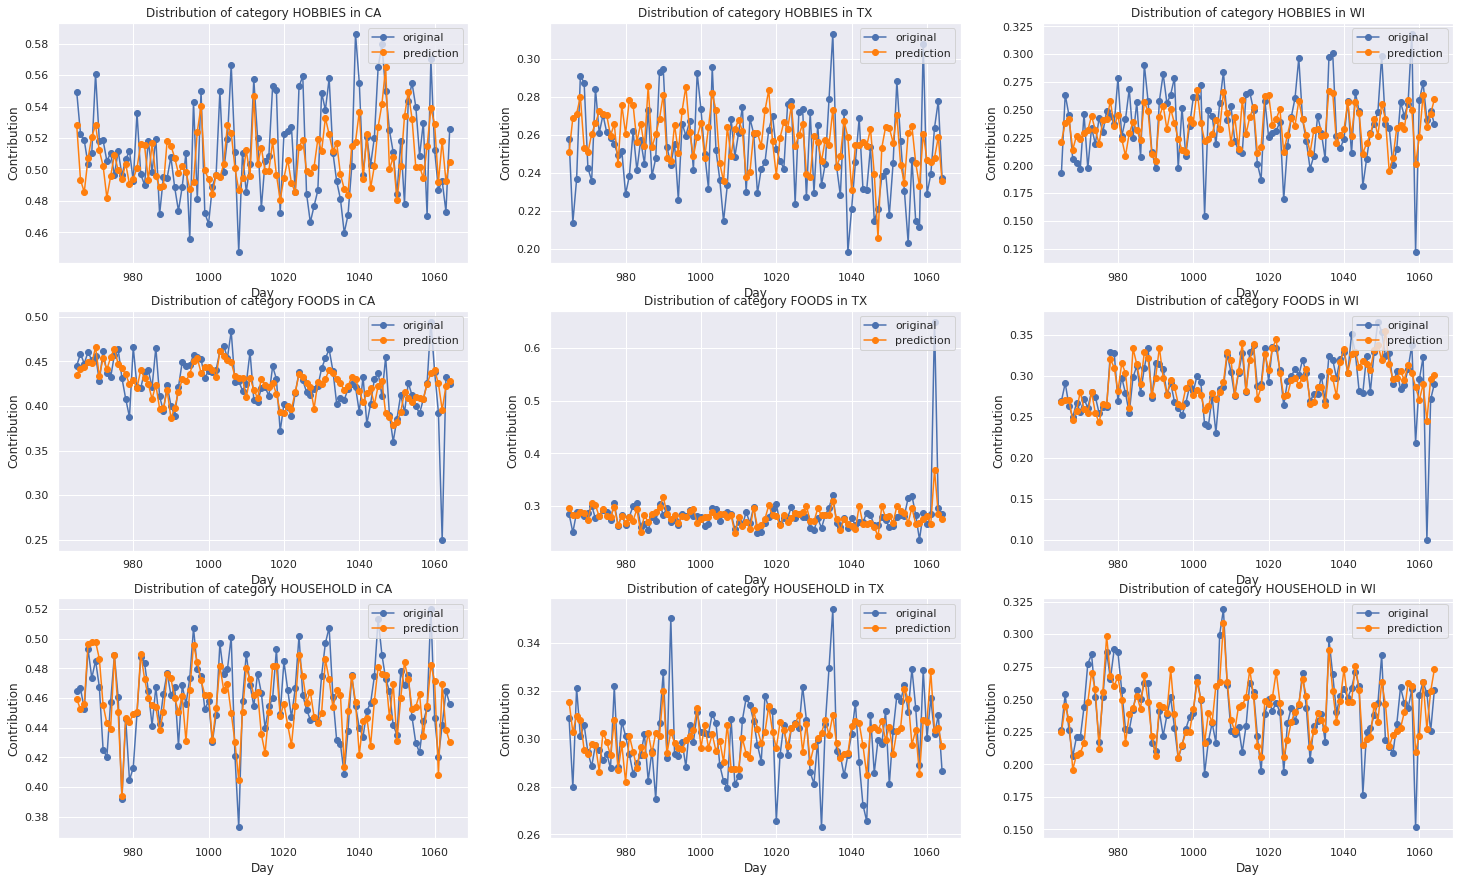

In [25]:
PlotGraphs(trainset, prediction_train, start=200, end=300)

### Plot the results for test data

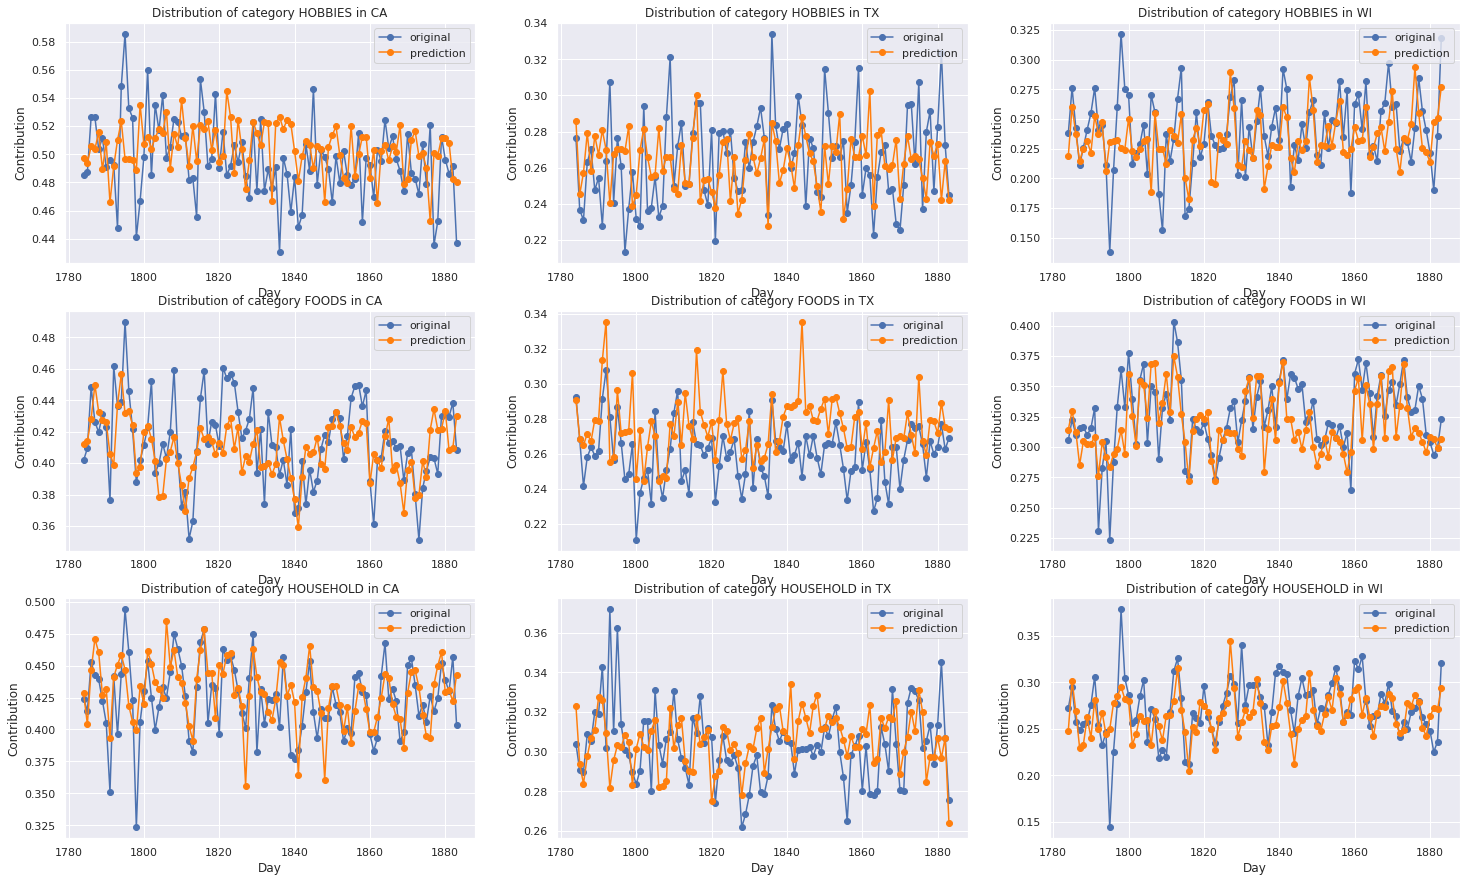

In [26]:
PlotGraphs(testset, predictions, start=100, end=200)